/var/folders/1f/f6ppdxmx41b_3v_dbrqd4sj00000gn/T/ipykernel_50294/1187532951.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap('tab20')
/var/folders/1f/f6ppdxmx41b_3v_dbrqd4sj00000gn/T/ipykernel_50294/1187532951.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  extra = plt.cm.get_cmap('Set3')


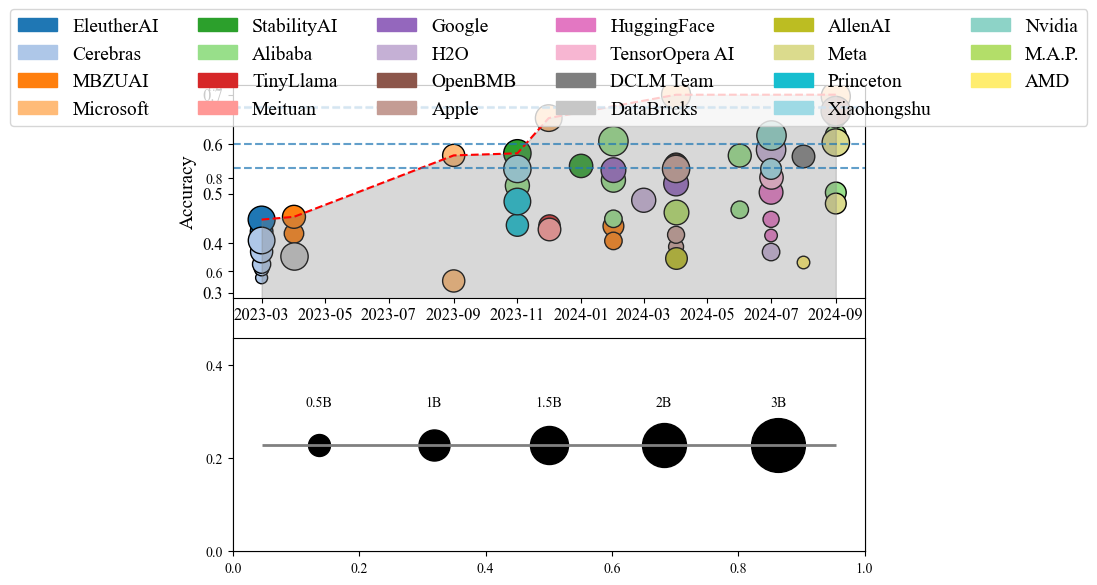

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.errors import ParserError

plt.rcParams.update({'font.family': 'Times New Roman'})

# 加载CSV文件
file_path = 'big-table.csv'
data = pd.read_csv(file_path)

# 处理日期格式的辅助函数
def parse_date(date_str):
    try:
        date_str = str(date_str)
        return pd.to_datetime(date_str, format='%Y.%m')
    except (ValueError, ParserError):
        try:
            return pd.to_datetime(date_str, format='%Y')
        except (ValueError, ParserError):
            return pd.NaT  # 如果日期格式未知，返回NaT

# 将指标转换为数值型并填充缺失值
data['Commonsense reasoning/understanding'] = pd.to_numeric(data['Commonsense reasoning/understanding'], errors='coerce').fillna(0.5)
data['Problem solving'] = pd.to_numeric(data['Problem solving'], errors='coerce').fillna(0.6)

# 计算两个指标的平均值
data['Average'] = (data['Commonsense reasoning/understanding'] + data['Problem solving']) / 2

# 填充“Parameters”中的缺失值
data['Parameters'] = data['Parameters'].fillna('1')

# 将“Parameters”转换为以B（十亿）为单位
def convert_params_to_gigabytes(param_str):
    try:
        if 'M' in param_str:
            return float(param_str.replace('M', '')) / 1e3  # 将M转换为B
        else:
            return float(param_str.replace('B', ''))  # 已经是B，直接返回
    except ValueError:
        print("error")
        return 1  # 如果解析错误，返回1

data['Parameters (G)'] = data['Parameters'].apply(convert_params_to_gigabytes)

# 应用日期解析函数
data['Release Date (Year.Month)'] = data['Release Date (Year.Month)'].apply(parse_date)

# 找到所有的LLaMA模型
llama_models = data[data['Model'].str.startswith('Llama', na=False)]

# 移除日期为空的行
data = data.dropna(subset=['Release Date (Year.Month)'])

# 只保留从2023年1月之后的数据
data = data[data['Release Date (Year.Month)'] >= pd.Timestamp('2023-01-01')]

# 根据affiliation设置颜色
data['affiliation'] = data['affiliation'].str.strip()
affiliations = data['affiliation'].unique()

# 生成自定义的颜色映射
def generate_color_map(n):
    base = plt.cm.get_cmap('tab20')
    extra = plt.cm.get_cmap('Set3')
    color_list = list(base(np.linspace(0, 1, 20)))  # 从'tab20'获取20种颜色
    if n > 20:
        extra_colors = list(extra(np.linspace(0, 1, n - 20)))  # 其余的颜色从'Set3'获取
        color_list.extend(extra_colors)
    return color_list[:n]

colors = generate_color_map(len(affiliations))
affiliation_color_map = {affiliation: colors[i] for i, affiliation in enumerate(affiliations)}

llama_family = ['LLaMA 1 (7B)', 'LLaMA 2 (7B)', 'LLaMA 3 (7B)', 'LLaMA 3.1 (7B)']

# 创建图表
plt.subplots(figsize=(10, 6))

# 绘制平均值随时间的变化
plt.subplot(2, 1, 1)
highest_values = []
for affiliation in affiliations:
    subset = data[data['affiliation'] == affiliation]
    plt.scatter(subset['Release Date (Year.Month)'], subset['Average'], 
                s=np.sqrt(subset['Parameters (G)']*50000), c=[affiliation_color_map[affiliation]], 
                edgecolors='k', label=affiliation)
    
    # 记录每个日期的最高平均值
    for date in subset['Release Date (Year.Month)'].unique():
        highest_value = subset[subset['Release Date (Year.Month)'] == date]['Average'].max()
        highest_values.append((date, highest_value))

# 转换为DataFrame并排序
highest_df = pd.DataFrame(highest_values, columns=['Date', 'Max Value']).drop_duplicates('Date').sort_values('Date')

# 如果需要，可以指定特定日期的值
timestamp_to_replace = pd.Timestamp('2024-09-01 00:00:00')
new_value = 0.70

# 替换特定日期的值
if timestamp_to_replace in highest_df['Date'].values:
    highest_df.loc[highest_df['Date'] == timestamp_to_replace, 'Max Value'] = new_value

# 确保'Max Value'列为数值类型
highest_df['Max Value'] = pd.to_numeric(highest_df['Max Value'], errors='coerce')

# 移除包含NaN的行
highest_df = highest_df.dropna(subset=['Date', 'Max Value'])

# 只保留上升的值和最后一个新点
highest_df = highest_df[highest_df['Max Value'].cummax() == highest_df['Max Value']]


# 重新获取最后一个新点
new = highest_df.iloc[-1]

# 如果需要，可以添加最后一个新点（根据实际情况）
# highest_df = pd.concat([highest_df, new.to_frame().T]).drop_duplicates('Date').sort_values('Date')

# 再次确保没有NaN值
highest_df = highest_df.dropna(subset=['Date', 'Max Value'])

# 绘制连接最高点的线
plt.plot(highest_df['Date'], highest_df['Max Value'], color='red', linestyle='--')

# 填充最高点和x轴之间的区域
plt.fill_between(highest_df['Date'], highest_df['Max Value'], 0, color='gray', alpha=0.3)

# 为LLaMA模型绘制水平线
for i, (_, llama) in enumerate(llama_models.iterrows()):
    plt.axhline(y=llama['Average'], linestyle='--', alpha=0.7)

# plt.title('Average of Commonsense Reasoning and Problem Solving')
plt.ylabel('Accuracy', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.xticks([])

# 自定义图例
from matplotlib.patches import Patch
legend_patches = [Patch(color=affiliation_color_map[affiliation], label=affiliation) for affiliation in affiliations]
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6, fontsize=14)
plt.ylim(0.29, 0.72)

# 绘制参数大小表示
plt.subplot(2, 1, 2)



# 要标注的关键参数大小
key_sizes = [0.5, 1, 1.5, 2, 3]  # 单位：十亿

# 正规化x位置以均匀间隔
x_positions = np.linspace(0.1, 0.9, len(sorted(key_sizes)))

# 绘制水平线
plt.hlines(y=1, xmin=0, xmax=1, colors='gray', linewidth=2)

# 绘制参数大小的散点图
for i, size in enumerate(sorted(key_sizes)):
    plt.scatter(x_positions[i], 1, s=size*500, color='k', edgecolors='k')
    plt.text(x_positions[i], 1.02, f"{size}B", horizontalalignment='center')


plt.yticks([])
plt.xticks([])



plt.tight_layout()
plt.savefig('./acc-evolution.pdf', bbox_inches='tight')
plt.show()

/var/folders/1f/f6ppdxmx41b_3v_dbrqd4sj00000gn/T/ipykernel_50294/2221208264.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap('tab20')
/var/folders/1f/f6ppdxmx41b_3v_dbrqd4sj00000gn/T/ipykernel_50294/2221208264.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  extra = plt.cm.get_cmap('Set3')


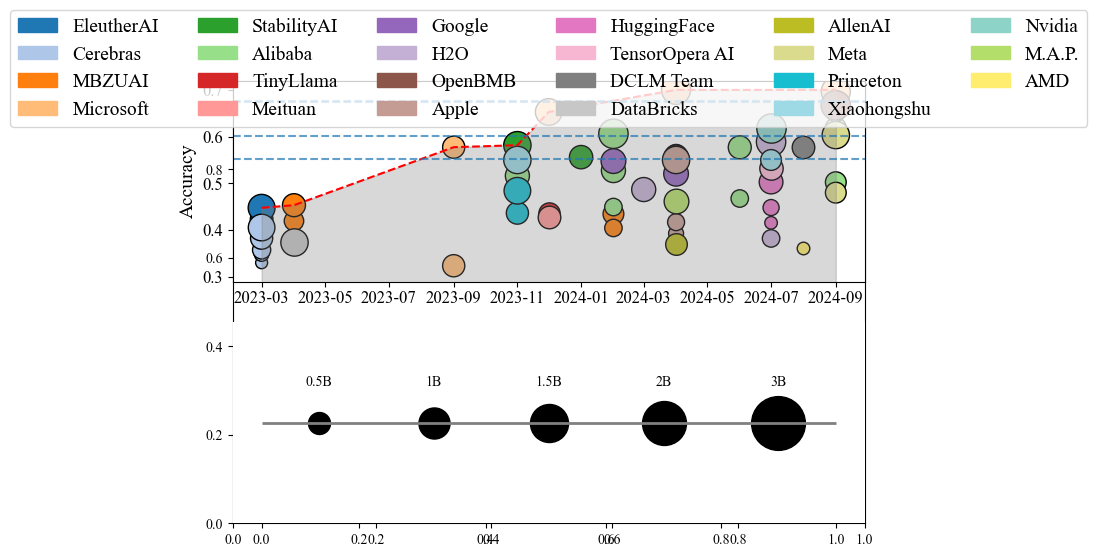

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.errors import ParserError

plt.rcParams.update({'font.family': 'Times New Roman'})

# 加载CSV文件
file_path = 'big-table.csv'
data = pd.read_csv(file_path)

# 处理日期格式的辅助函数
def parse_date(date_str):
    try:
        date_str = str(date_str)
        return pd.to_datetime(date_str, format='%Y.%m')
    except (ValueError, ParserError):
        try:
            return pd.to_datetime(date_str, format='%Y')
        except (ValueError, ParserError):
            return pd.NaT  # 如果日期格式未知，返回NaT

# 将指标转换为数值型并填充缺失值
data['Commonsense reasoning/understanding'] = pd.to_numeric(data['Commonsense reasoning/understanding'], errors='coerce').fillna(0.5)
data['Problem solving'] = pd.to_numeric(data['Problem solving'], errors='coerce').fillna(0.6)

# 计算两个指标的平均值
data['Average'] = (data['Commonsense reasoning/understanding'] + data['Problem solving']) / 2

# 填充“Parameters”中的缺失值
data['Parameters'] = data['Parameters'].fillna('1')

# 将“Parameters”转换为以B（十亿）为单位
def convert_params_to_gigabytes(param_str):
    try:
        if 'M' in param_str:
            return float(param_str.replace('M', '')) / 1e3  # 将M转换为B
        else:
            return float(param_str.replace('B', ''))  # 已经是B，直接返回
    except ValueError:
        print("error")
        return 1  # 如果解析错误，返回1

data['Parameters (G)'] = data['Parameters'].apply(convert_params_to_gigabytes)

# 应用日期解析函数
data['Release Date (Year.Month)'] = data['Release Date (Year.Month)'].apply(parse_date)

# 找到所有的LLaMA模型
llama_models = data[data['Model'].str.startswith('Llama', na=False)]

# 移除日期为空的行
data = data.dropna(subset=['Release Date (Year.Month)'])

# 只保留从2023年1月之后的数据
data = data[data['Release Date (Year.Month)'] >= pd.Timestamp('2023-01-01')]

# 根据affiliation设置颜色
data['affiliation'] = data['affiliation'].str.strip()
affiliations = data['affiliation'].unique()

# 生成自定义的颜色映射
def generate_color_map(n):
    base = plt.cm.get_cmap('tab20')
    extra = plt.cm.get_cmap('Set3')
    color_list = list(base(np.linspace(0, 1, 20)))  # 从'tab20'获取20种颜色
    if n > 20:
        extra_colors = list(extra(np.linspace(0, 1, n - 20)))  # 其余的颜色从'Set3'获取
        color_list.extend(extra_colors)
    return color_list[:n]

colors = generate_color_map(len(affiliations))
affiliation_color_map = {affiliation: colors[i] for i, affiliation in enumerate(affiliations)}

llama_family = ['LLaMA 1 (7B)', 'LLaMA 2 (7B)', 'LLaMA 3 (7B)', 'LLaMA 3.1 (7B)']

# 创建图表
plt.subplots(figsize=(10, 6))

# 绘制平均值随时间的变化
plt.subplot(2, 1, 1)
highest_values = []
for affiliation in affiliations:
    subset = data[data['affiliation'] == affiliation]
    plt.scatter(subset['Release Date (Year.Month)'], subset['Average'], 
                s=np.sqrt(subset['Parameters (G)']*50000), c=[affiliation_color_map[affiliation]], 
                edgecolors='k', label=affiliation)
    
    # 记录每个日期的最高平均值
    for date in subset['Release Date (Year.Month)'].unique():
        highest_value = subset[subset['Release Date (Year.Month)'] == date]['Average'].max()
        highest_values.append((date, highest_value))

# 转换为DataFrame并排序
highest_df = pd.DataFrame(highest_values, columns=['Date', 'Max Value']).drop_duplicates('Date').sort_values('Date')

# 如果需要，可以指定特定日期的值
timestamp_to_replace = pd.Timestamp('2024-09-01 00:00:00')
new_value = 0.70

# 替换特定日期的值
if timestamp_to_replace in highest_df['Date'].values:
    highest_df.loc[highest_df['Date'] == timestamp_to_replace, 'Max Value'] = new_value

# 确保'Max Value'列为数值类型
highest_df['Max Value'] = pd.to_numeric(highest_df['Max Value'], errors='coerce')

# 移除包含NaN的行
highest_df = highest_df.dropna(subset=['Date', 'Max Value'])

# 只保留上升的值和最后一个新点
highest_df = highest_df[highest_df['Max Value'].cummax() == highest_df['Max Value']]


# 重新获取最后一个新点
new = highest_df.iloc[-1]

# 如果需要，可以添加最后一个新点（根据实际情况）
# highest_df = pd.concat([highest_df, new.to_frame().T]).drop_duplicates('Date').sort_values('Date')

# 再次确保没有NaN值
highest_df = highest_df.dropna(subset=['Date', 'Max Value'])

# 绘制连接最高点的线
plt.plot(highest_df['Date'], highest_df['Max Value'], color='red', linestyle='--')

# 填充最高点和x轴之间的区域
plt.fill_between(highest_df['Date'], highest_df['Max Value'], 0, color='gray', alpha=0.3)

# 为LLaMA模型绘制水平线
for i, (_, llama) in enumerate(llama_models.iterrows()):
    plt.axhline(y=llama['Average'], linestyle='--', alpha=0.7)

# plt.title('Average of Commonsense Reasoning and Problem Solving')
plt.ylabel('Accuracy', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# plt.xticks([])

# 自定义图例
from matplotlib.patches import Patch
legend_patches = [Patch(color=affiliation_color_map[affiliation], label=affiliation) for affiliation in affiliations]
plt.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=6, fontsize=14)
plt.ylim(0.29, 0.72)

# 绘制参数大小表示
plt.subplot(2, 1, 2)



# 要标注的关键参数大小
key_sizes = [0.5, 1, 1.5, 2, 3]  # 单位：十亿

# 正规化x位置以均匀间隔
x_positions = np.linspace(0.1, 0.9, len(sorted(key_sizes)))

# 绘制水平线
plt.hlines(y=1, xmin=0, xmax=1, colors='gray', linewidth=2)

# 绘制参数大小的散点图
for i, size in enumerate(sorted(key_sizes)):
    plt.scatter(x_positions[i], 1, s=size*500, color='k', edgecolors='k')
    plt.text(x_positions[i], 1.02, f"{size}B", horizontalalignment='center')

# 移除边框
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.yticks([])
# plt.xticks([])
# 设置折叠区域



plt.tight_layout()
plt.savefig('./acc-evolution.pdf', bbox_inches='tight')
plt.show()